In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Custom DataLoader (Assuming you have this defined)
from DataLoader import Data_Loader

b:\pythonProjects\MelanomaClassification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_df = pd.read_csv('data/train.csv')  
train_df = train_df.drop(['tfrecord','width','height'],axis=1)
train_df.head()

In [ ]:
from sklearn import model_selection


df = train_df.sample(frac=1).reset_index(drop=True)
df['kfold'] = -1
y = train_df.target.values
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
idx = kf.get_n_splits(X=df,y=y)

for fold,(x,y) in enumerate(kf.split(X=df,y=y)):
    df.loc[y,'kfold'] = fold
df.to_csv('train_fold_tpu.csv',index=False)

In [3]:
df = pd.read_csv('train_fold_tpu.csv')

Subset smaller for faster training and fine tuning the parameters

In [ ]:
# Select one fold for initial tuning (e.g., fold 0)
tuning_fold = df[df['kfold'] == 0].reset_index(drop=True)
test_df = df[df['kfold']==1].reset_index(drop=True)
# Check class distribution for confirmation
print(tuning_fold['target'].value_counts())
print(test_df['target'].value_counts())

In [2]:
from efficientnet_pytorch import EfficientNet 

class EfficientNetClassifier(nn.Module):
    def __init__(self, model_version='b4', num_classes=1, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()
        
        model_name = f'efficientnet-{model_version}'
        # Instance of the EfficientNet model with pre-trained weights
        self.feature_extractor = EfficientNet.from_pretrained(model_name)
        
        # Get the number of input features from the last layer of EfficientNet
        num_features = self.feature_extractor._fc.in_features
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        batch_size = images.shape[0]
        
        # Extract features using the EfficientNet model
        features = self.feature_extractor.extract_features(images)
        
        # Pool and reshape features
        pooled_features = nn.functional.adaptive_avg_pool2d(features, 1).reshape(batch_size, -1)
        
        # Pass pooled features through the classifier
        output = self.classifier(pooled_features)
        
        return output  # Return logits directly

In [3]:
model = EfficientNetClassifier(model_version='b4', num_classes=1, dropout_rate=0.5)


class EarlyStopping:
    def __init__(self, patience=7, mode="min", delta=0):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif (self.mode == "min" and score > self.best_score - self.delta) or \
             (self.mode == "max" and score < self.best_score + self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.early_stop

# Configuration Parameters
CONFIG = {
    'normalization_mean': (0.485, 0.456, 0.406),
    'normalization_std': (0.229, 0.224, 0.225),
    'image_size': (384, 384),
    'batch_size': 26,
    'num_epochs': 5,
    'learning_rate': 3e-5,
    'weight_decay': 1e-4,
    'early_stopping_patience': 10,
}

# Define Focal Loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

Loaded pretrained weights for efficientnet-b4


This is a similar version of training but for the small subset of fold 0 for training and fold 1 for validating, also use AMP for faster training time

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for data, labels in tqdm(dataloader):
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        scaler = torch.amp.GradScaler("cuda")
        # Use AMP for mixed precision training
        with torch.amp.autocast("cuda"):
            outputs = model(data)
            loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass with AMP scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * data.shape[0]
        prob_outputs = torch.sigmoid(outputs).detach().cpu().numpy()
        predictions.extend(prob_outputs.flatten())
        targets.extend(labels.cpu().numpy())
        
    return total_loss / len(dataloader.dataset), predictions, targets

# Validation epoch function with AMP
def validate_epoch(model, dataloader, criterion, device, scaler):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data, labels in tqdm(dataloader):
            data, labels = data.to(device), labels.to(device)
            
            # Use AMP for mixed precision inference
            with torch.amp.autocast('cuda'):
                outputs = model(data)
                loss = criterion(outputs, labels.unsqueeze(1))
            
            total_loss += loss.item() * data.shape[0]
            prob_outputs = torch.sigmoid(outputs).detach().cpu().numpy()
            predictions.extend(prob_outputs.flatten())
            targets.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader.dataset), predictions, targets


In [7]:
def get_train_transforms():
    return A.Compose([
        A.Normalize(mean=CONFIG['normalization_mean'], std=CONFIG['normalization_std'], max_pixel_value=255.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        A.CLAHE(clip_limit=4.0, p=0.7),
        ToTensorV2(),
    ])

def get_valid_transforms():
    return A.Compose([
        A.Normalize(mean=CONFIG['normalization_mean'], std=CONFIG['normalization_std'], max_pixel_value=255.0),
        ToTensorV2(),
    ])

# Modify your optimizer and scheduler here
def train_model(model, train_fold, valid_fold, df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load data transformations
    train_transforms = get_train_transforms()
    valid_transforms = get_valid_transforms()
    
    # Prepare training and validation datasets from specified folds
    image_directory = 'data/train'
    train_df = df[df.kfold == train_fold].reset_index(drop=True)
    valid_df = df[df.kfold == valid_fold].reset_index(drop=True)

    train_dataset = Data_Loader(image_directory, train_df.image_name.tolist(), train_df.target.values, train_transforms).dataset
    valid_dataset = Data_Loader(image_directory, valid_df.image_name.tolist(), valid_df.target.values, valid_transforms).dataset

    # WeightedRandomSampler for handling class imbalance
    class_sample_counts = train_df['target'].value_counts().sort_index().values
    class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    sample_weights = class_weights[train_df['target'].values]
    weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # DataLoader with WeightedRandomSampler for training
    train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=4, pin_memory=True, batch_size=CONFIG['batch_size'], sampler=weighted_sampler)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, num_workers=4, pin_memory=True, batch_size=CONFIG['batch_size'], shuffle=False)
    
    model.to(device)
    loss_criterion = FocalLoss(alpha=0.5, gamma=2.0).to(device)

    # Use AdamW optimizer with weight decay for better generalization
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

    # Scheduler: CosineAnnealingWarmRestarts or ReduceLROnPlateau
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    # Or you could use ReduceLROnPlateau
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    # Initialize AMP scaler
    scaler = torch.amp.GradScaler('cuda')

    best_valid_pr_auc = 0.0
    best_model = None
    no_improve_epochs = 0

    for epoch in range(CONFIG['num_epochs']):
        # Training phase
        model.train()
        train_loss, train_predictions, train_targets = train_epoch(model, train_loader, loss_criterion, optimizer, device, scaler)
        
        # Validation phase
        model.eval()
        valid_loss, valid_predictions, valid_targets = validate_epoch(model, valid_loader, loss_criterion, device, scaler)
        
        # Calculate PR AUC scores
        train_pr_auc = average_precision_score(train_targets, train_predictions)
        valid_pr_auc = average_precision_score(valid_targets, valid_predictions)
        train_f1 = f1_score(train_targets, np.round(train_predictions), pos_label=1, zero_division=0)
        valid_f1 = f1_score(valid_targets, np.round(valid_predictions), pos_label=1, zero_division=0)
        print(f"Train F1-Score: {train_f1:.4f}")
        print(f"Valid F1-Score: {valid_f1:.4f}")

        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Train Loss: {train_loss:.4f}, Train PR AUC: {train_pr_auc:.4f}, Valid Loss: {valid_loss:.4f}, Valid PR AUC: {valid_pr_auc:.4f}")

        # Update learning rate scheduler
        scheduler.step()  # If using CosineAnnealingWarmRestarts
        # scheduler.step(valid_pr_auc)  # If using ReduceLROnPlateau, use validation PR AUC to trigger adjustments
        
        # Save the best model based on validation PR AUC
        if valid_pr_auc > best_valid_pr_auc:
            best_valid_pr_auc = valid_pr_auc
            best_model = model.state_dict().copy()
            no_improve_epochs = 0
            print("New best model saved based on validation PR AUC")
        else:
            no_improve_epochs += 1
        
        # Early stopping condition
        if no_improve_epochs >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement in PR AUC")
            break

        torch.cuda.empty_cache()
    
    model.load_state_dict(best_model)
    return model, best_model



In [8]:
cur_model, best_model = train_model(model, 0, 1 , df)
torch.save(best_model,'effnetb4.pth')

100%|██████████| 255/255 [00:44<00:00,  5.72it/s]


Train F1-Score: 0.8948
Valid F1-Score: 0.5799
Epoch 1/5: Train Loss: 0.0327, Train PR AUC: 0.9661, Valid Loss: 0.0052, Valid PR AUC: 0.8539
New best model saved based on validation PR AUC


100%|██████████| 255/255 [00:44<00:00,  5.70it/s]


Train F1-Score: 0.9892
Valid F1-Score: 0.9333
Epoch 2/5: Train Loss: 0.0061, Train PR AUC: 0.9994, Valid Loss: 0.0011, Valid PR AUC: 0.9978
New best model saved based on validation PR AUC


100%|██████████| 255/255 [00:44<00:00,  5.74it/s]


Train F1-Score: 0.9958
Valid F1-Score: 0.9520
Epoch 3/5: Train Loss: 0.0033, Train PR AUC: 0.9998, Valid Loss: 0.0008, Valid PR AUC: 0.9988
New best model saved based on validation PR AUC


100%|██████████| 255/255 [00:44<00:00,  5.71it/s]


Train F1-Score: 0.9943
Valid F1-Score: 0.9831
Epoch 4/5: Train Loss: 0.0029, Train PR AUC: 0.9998, Valid Loss: 0.0004, Valid PR AUC: 1.0000
New best model saved based on validation PR AUC


100%|██████████| 255/255 [00:44<00:00,  5.69it/s]

Train F1-Score: 0.9979
Valid F1-Score: 0.9787
Epoch 5/5: Train Loss: 0.0018, Train PR AUC: 0.9999, Valid Loss: 0.0004, Valid PR AUC: 1.0000


In [ ]:
model_tuning = EfficientNetClassifier(model_version='b4', num_classes=1, dropout_rate=0.3)
model_tuning.load_state_dict(torch.load('subset_tuning.pth',weights_only=True))

cur_model, best_model = train_model(model, 0, 1 , df)
torch.save(best_model,'subset_tuning.pth')


This is a full scale of training data and validating data from 5 Fold( 4 for training 1 for validating)

In [9]:
def predict(fold, true_labels=None):
    test_df = pd.read_csv('data/test.csv')
    im_path = 'data/test/'
    batch_t = 32    
    model_path = f'effnetb4.pth' 
    
    test_im = test_df.image_name.values.tolist()
    test_y = np.ones(len(test_im))  # Dummy labels since this is a test set
    
    # Define augmentation pipeline (if needed)
    augmentation_pipeline = A.Compose([
        A.Resize(height=384, width=384),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # Create DataLoader for the test dataset
    test_dataset = Data_Loader(im_path, test_im, test_y, augmentation_pipeline)
    test_loader = test_dataset.get(batch_size=batch_t, shuffle=False, num_workers=6)
    
    print(f'Number of batches in test_loader: {len(test_loader)}')
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize the model and load weights
    model.load_state_dict(torch.load(model_path, weights_only=True),strict=False)
    model.to(device)
    model.eval()
    
    preds = []
    
    # Iterate over batches in the DataLoader
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_idx, (test_data, _) in enumerate(test_loader):
            test_data = test_data.to(device)  # Move data to GPU
            
            out = model(test_data)  # Forward pass through the model
            
            preds.append(out.cpu())  # Store logits on CPU
            
            if batch_idx % 50 == 0:
                print(f'Processed batch {batch_idx}')
    
    pred_array = np.vstack(preds).ravel()  # Combine predictions into a single array

    # Convert probabilities to binary predictions based on a threshold of 0.5
    predicted_classes = (pred_array > 0.5).astype(int)

    # Calculate F1 score if true labels are provided
    if true_labels is not None:
        f1 = f1_score(true_labels, predicted_classes)
        print(f"F1 Score: {f1:.4f}")
        return predicted_classes, f1

    return predicted_classes

In [10]:
from DataLoader import Data_Loader
prediction = predict(2)
submission = pd.read_csv('data/sample_submission.csv')
submission.loc[:,'target'] = prediction
submission.to_csv('submission.csv',index=False)


Number of batches in test_loader: 344
Processed batch 0
Processed batch 50
Processed batch 100
Processed batch 150
Processed batch 200
Processed batch 250
Processed batch 300


In [ ]:
submission[submission['target']==1]
submission.describe()


In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score

def evaluate_model(model, valid_dataset, device):
    model.eval()  
    valid_predictions = []
    valid_targets = []

    with torch.no_grad():
        for valid_data, valid_label in valid_dataset:
            valid_data = valid_data.to(device)
            out = model(valid_data)
            out = torch.sigmoid(out)

            valid_targets.append(valid_label.to(device))  
            valid_predictions.append(out)

    valid_predictions = torch.cat(valid_predictions).cpu()
    valid_targets = torch.cat(valid_targets).cpu()

    # Calculate ROC AUC
    valid_auc_score = roc_auc_score(valid_targets.numpy(), valid_predictions.numpy())
    print(f"AUC: {valid_auc_score:.4f}")

    # Calculate Precision-Recall AUC (PR AUC)
    valid_pr_auc_score = average_precision_score(valid_targets.numpy(), valid_predictions.numpy())
    print(f"PR AUC: {valid_pr_auc_score:.4f}")

    # Find best threshold based on Precision and Recall
    thresholds = np.arange(0.4, 0.5, 0.1)  # Adjusted range to include 0.35
    best_recall = best_precision = best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        predicted_classes = (valid_predictions > threshold).int()
        precision = precision_score(valid_targets.numpy(), predicted_classes.numpy(), zero_division=0)
        recall = recall_score(valid_targets.numpy(), predicted_classes.numpy(), zero_division=0)
        f1 = f1_score(valid_targets, predicted_classes, zero_division=0)
        if f1 > best_f1:
            best_recall = recall
            best_precision = precision
            best_threshold = threshold
            best_f1 = f1

        print(f"Threshold: {threshold:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    print(f"Best Precision: {best_precision:.4f}, Best Recall: {best_recall:.4f} at Threshold: {best_threshold:.4f}", f"Best F1: {best_f1:.4f}")

    from sklearn.metrics import precision_recall_curve

    # Calculate Precision-Recall values for different thresholds for plotting
    precisions, recalls, thresholds_pr = precision_recall_curve(valid_targets.numpy(), valid_predictions.numpy())

    # Plot Precision-Recall trade-off curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds_pr, precisions[:-1], label="Precision", color='b')
    plt.plot(thresholds_pr, recalls[:-1], label="Recall", color='r')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall Trade-off Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


    # Display Confusion Matrix at best threshold
    final_predicted_classes = (valid_predictions > best_threshold).int()
    cm = confusion_matrix(valid_targets.numpy(), final_predicted_classes.numpy())

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return cm


C:\Users\Thanh\AppData\Local\Temp\ipykernel_23956\1688006951.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


AUC: 1.0000
PR AUC: 0.9981
Threshold: 0.5000, Precision: 1.0000, Recall: 0.9730
Best Precision: 1.0000, Best Recall: 0.9730 at Threshold: 0.5000 Best F1: 0.9863


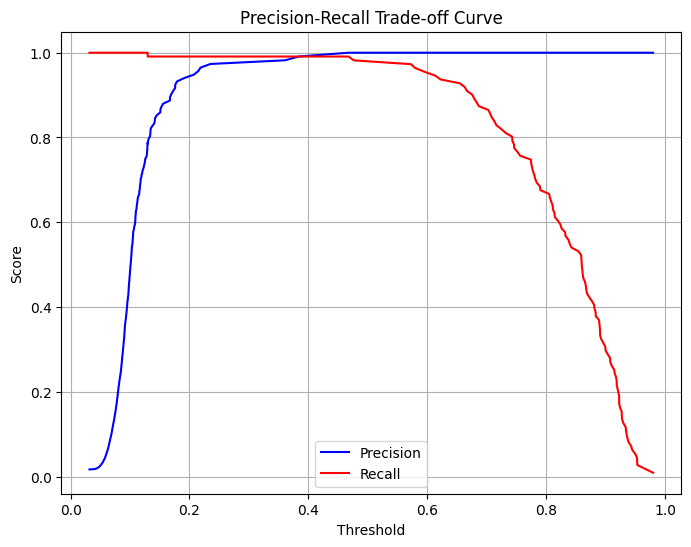

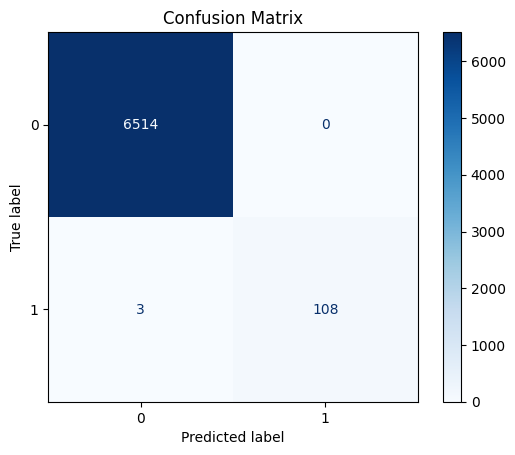

Confusion Matrix:
[[6514    0]
 [   3  108]]


In [19]:
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch
import pandas as pd

# Assuming evaluate_model and Data_Loader are defined properly
if __name__ == "__main__":
    fold_number = 4
    
    # Load your trained model
    model_path = "effnetb4.pth"
    model.load_state_dict(torch.load(model_path))
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Create validation dataset for generating the confusion matrix
    image_path = 'data/train'
    valid_df = df[df.kfold == fold_number].reset_index(drop=True)
    
    valid_im = valid_df.image_name.values.tolist()
    valid_y = valid_df.target.values
    
    

    # Validation transformations
    valid_transpose = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
        ToTensorV2()
    ])
    
    # Loading validation dataset
    valid_dataset = Data_Loader(image_path, valid_im, valid_y, valid_transpose).get(batch_size=32, shuffle=False, num_workers=6)

    # Generate and print confusion matrix and metrics
    cm = evaluate_model(model, valid_dataset, device)


This is testing with ISSIC 2019 images to verify the accuracy of the model

C:\Users\Thanh\AppData\Local\Temp\ipykernel_13988\2007689959.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Number of overlapping images: 0
AUC: 0.9997
PR AUC: 0.9997
Threshold: 0.4000, Precision: 0.9996, Recall: 0.9684
Best Precision: 0.9996, Best Recall: 0.9684 at Threshold: 0.4000 Best F1: 0.9837


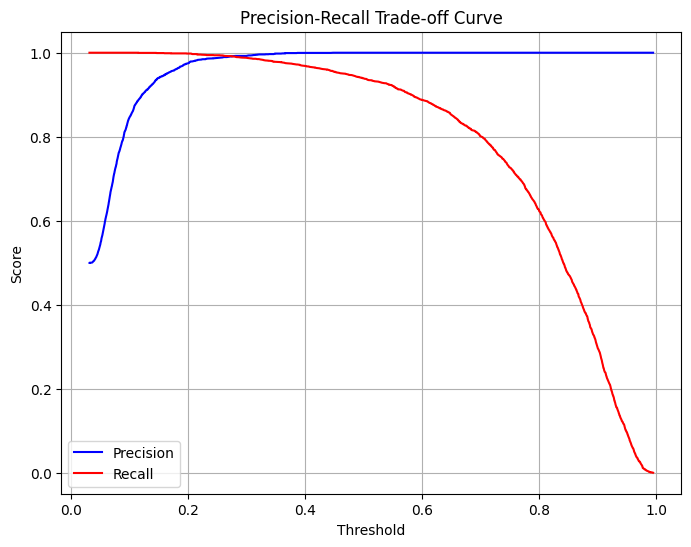

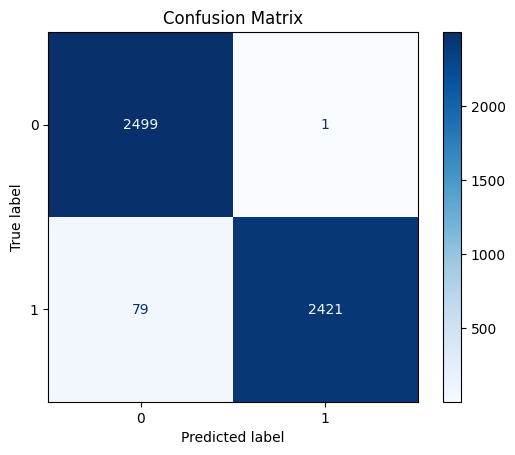

In [14]:
import torch
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import hashlib

model_path = "effnetb4.pth"
model.load_state_dict(torch.load(model_path))
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Load the train dataset (ISIC 2020) and test dataset (ISIC 2019)
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test_ISIC_2019/ISIC_2019_Training_GroundTruth.csv')

# Rename and drop unnecessary columns in the test dataset
df_test.rename(columns={"MEL": 'target'}, inplace=True)
df_test.drop(columns=['NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], inplace=True)

# Identify and remove overlapping images
# Assuming image filenames are in the 'image_name' column
common_images = set(df_train['image_name']).intersection(set(df_test['image']))
print(f"Number of overlapping images: {len(common_images)}")
df_test_filtered = df_test[~df_test['image'].isin(common_images)]

# Determine the number of samples to take
total_samples = 5000
positive_samples = 2500  # Number of samples with target = 1 (adjust as needed)
negative_samples = total_samples - positive_samples

# Sample positive and negative cases
df_positive = df_test_filtered[df_test_filtered['target'] == 1].sample(n=positive_samples, random_state=90)
df_negative = df_test_filtered[df_test_filtered['target'] == 0].sample(n=negative_samples, random_state=3)

# Combine the sampled DataFrames
df_sampled = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Prepare image and target lists
test_im = df_sampled.image.values.tolist()
test_target = df_sampled.target.values.tolist()

# Define validation transformations
valid_transpose = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
    ToTensorV2()
])

# Loading validation dataset
test_dataset = Data_Loader('data/test_ISIC_2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input', test_im, test_target, valid_transpose).get(batch_size=32, shuffle=False, num_workers=6)

# Generate and print confusion matrix and metrics
cm = evaluate_model(model, test_dataset, device)